## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [1]:
## 
"""
Your code here (optional)
確認硬體資源
"""
# !nvidia-smi

In [12]:
import os
import keras
import tensorflow as tf
# 請嘗試設定 GPU：os.environ
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 自動增長 GPU 記憶體用量
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.55) #占用55%顯存
sess =  tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [13]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
# 載入資料（將資料打散，放入 train 與 test 資料集）
train, test = keras.datasets.cifar10.load_data()

In [14]:
## 資料前處理
"""
Your code here
"""
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = 2*(((x - x.min()) / (x.max() - x.min()))-0.5) # values from -1 to 1
    # (x - x.min()) / (x.max() - x.min()) # values from 0 to 1
    # (x - x.mean()) / x.std() # values from ? to ?, but mean at 0
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [15]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 512, 256, 256, 256, 128, 128, 128, 64, 64]):
    
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            # Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            # Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
            # Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
    
    # 定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# 定義一個具有輸入和輸出的模型
model = build_mlp(input_shape=x_train.shape[1:])
# 用 Keras 內建方法檢視模型各層參數量
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer4 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer5 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer6 (Dense)        (None, 128)               3289

In [17]:
## 超參數設定
LEARNING_RATE = 0.001 # 學習率
EPOCHS = 100  # 訓練100週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）

In [18]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
'''
參數說明:
•lr：float >= 0. 學習率。
• beta_1：float, 0 < beta < 1. 通常接近於 1。
• beta_2：float, 0 < beta < 1. 通常接近於 1。
• epsilon：float >= 0. 模糊因數. 若為 None, 默認為 K.epsilon()。
• amsgrad：boolean. 是否應用此演算法的 AMSGrad 變種，來自論文 「On the Convergence of Adam and
Beyond」
• decay：float >= 0. 每次參數更新後學習率衰減值。
'''

'\n參數說明:\n•lr：float >= 0. 學習率。\n• beta_1：float, 0 < beta < 1. 通常接近於 1。\n• beta_2：float, 0 < beta < 1. 通常接近於 1。\n• epsilon：float >= 0. 模糊因數. 若為 None, 默認為 K.epsilon()。\n• amsgrad：boolean. 是否應用此演算法的 AMSGrad 變種，來自論文 「On the Convergence of Adam and\nBeyond」\n• decay：float >= 0. 每次參數更新後學習率衰減值。\n'

In [19]:
model.fit(x_train, y_train,  # 訓練資料
          epochs=EPOCHS, # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
          batch_size=BATCH_SIZE,  # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
          validation_data=(x_test, y_test), # 驗證資料
          shuffle=True) # 每次epochs後，將訓練集打亂順序

'''
注意：使用 validation_split 與 shuffle 時，
Keras 是先自 x_train/y_train 取最後 (1-x)% 做為驗證集使用，
再行 shuffle
'''

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 172us/step - loss: 1.7750 - accuracy: 0.3626 - val_loss: 1.6066 - val_accuracy: 0.4249
Epoch 2/100
50000/50000 [==============================] - 8s 169us/step - loss: 1.5245 - accuracy: 0.4617 - val_loss: 1.4748 - val_accuracy: 0.4745
Epoch 3/100
50000/50000 [==============================] - 9s 173us/step - loss: 1.3958 - accuracy: 0.5064 - val_loss: 1.4221 - val_accuracy: 0.5000
Epoch 4/100
50000/50000 [==============================] - 9s 172us/step - loss: 1.2883 - accuracy: 0.5447 - val_loss: 1.3615 - val_accuracy: 0.5215
Epoch 5/100
50000/50000 [==============================] - 9s 177us/step - loss: 1.1948 - accuracy: 0.5805 - val_loss: 1.3644 - val_accuracy: 0.5227
Epoch 6/100
50000/50000 [==============================] - 8s 169us/step - loss: 1.1229 - accuracy: 0.6055 - val_loss: 1.3626 - val_accuracy: 0.5284
Epoch 7/100
50000/50000 [==============================]

'\n注意：使用 validation_split 與 shuffle 時，\nKeras 是先自 x_train/y_train 取最後 (1-x)% 做為驗證集使用，\n再行 shuffle\n'

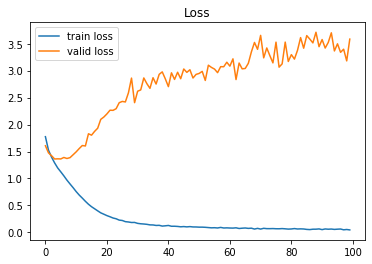

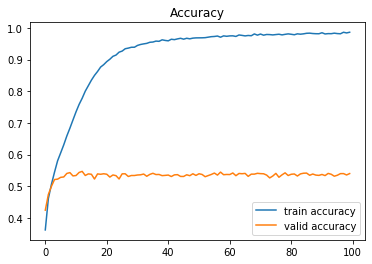

In [22]:
import matplotlib.pyplot as plt


train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()